In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4 as nc
import h5py
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4 as nc
from numba import jit,njit,prange
from numpy import linalg
from time import sleep
from tqdm import tqdm, trange
import torch, torch.linalg
from numpy import exp, abs, angle


In [2]:

def jacobian(x_0,x_1,bias):
#---modified 0403---------
    lenx = np.shape(x_0)[1]
    jaco = linalg.inv(x_0.T@x_0+bias*np.eye(lenx))@x_0.T@x_1
    return jaco


def jacobian_effective(x_0,x_1):
#---modified 0403---------#
    lenx = np.shape(x_0)[1]
    jaco = linalg.inv(x_1.T@x_0)@x_1.T@x_1
    return jaco

def foward_wide2(x_ini,jaco,steps,name=False):
    # for lorenz model , len(x_ini) = 3
    lenx = np.shape(x_ini)[0]
    output = np.zeros((steps,lenx))
    output[0,:] = x_ini
    if name == False:  
        for i in range(steps-1):
            temp        = widedata_2(output[i].reshape((1,lenx))).flatten()
            temp2       = np.hstack((output[i],temp))
            out_wide    = jaco@temp2
            output[i+1] = out_wide[:lenx]
        return output
    else: 
        for i in range(steps-1):
            temp        = widedata_2(output[i].reshape((1,lenx))).flatten()
            temp2       = np.hstack((output[i],temp))
            temp3       = np.delete(temp2,np.array(name), axis=0)
            out_wide    = jaco@temp3
            output[i+1] = out_wide[:lenx]
        return output
def widedata_2(a):
    a = np.array(a)
    dim = len(np.shape(a))
    time = np.shape(a)[0]    # length of time
    state = np.shape(a)[1]   # length of state vector
    
    # generate a bigger array to store tensored data
    t0 = np.ones(state)
    temp = np.kron(t0,t0)*np.nan
    state_big = np.shape(temp.flatten())[0]
    output = np.nan*np.zeros((time,state_big))
    #print(temp.shape)
    #print(output.shape)
    for i in range(time):
        state_now = a[i,:]
        temp0 = np.kron(state_now,state_now)
        size = temp0.shape[0]
        output[i,:size] = temp0
    #output2 = output[~(output==0)]
    #shape2 = int(len(output2)/time)
    return output

In [12]:
def find_nearest(point,a,persent):
    # a : the array contains the point
    # a : (time, points)
    # persent : nearest 
    # return : indexs
    size      = a.shape[0]
    k         = int(size*persent)
    points    = np.tile(point,(size,1))
    norm      = np.sum((points-a)**2,axis=1)
    
    top_k_idx = norm.argsort()[::1][0:k]
    return top_k_idx

def det_real_data(data,persent,bias):  # data: 2D array
    size = data.shape[0]  # time variable
    num  = data.shape[1]  # space variable
    det  = np.zeros(size)
    for i in tqdm(range(size)): 
        p = data[i]
        idx = find_nearest(p,data,persent)
        idx = idx[idx+1<size-1]
        x_0 = data[idx,:]
        x_1 = data[idx+1,:]
        #----------------------A = torch.Tensor(x_0.T@x_0+bias*np.eye(num))
        #----------------------jaco   = torch.linalg.inv(A)@x_0.T@x_1
        A = torch.Tensor(x_1.T@x_0+bias*np.eye(num))
        jaco   = torch.linalg.inv(A)@x_1.T@x_1
        det[i] = torch.linalg.det(torch.Tensor(jaco)).item()
    return det

def foward(x_ini,jaco,steps):
    lenx = np.shape(x_ini)[0]
    output = np.zeros((steps,lenx))
    output[0,:] = x_ini
    for i in range(steps-1):
        output[i+1] = output[i]@jaco
    return output

In [20]:
def det_real_data_2(data,data2,persent,bias):  # data: grids [??,2]    data2: original data ,[?,2]
    size = data.shape[0]  # time variable
    num  = data.shape[1]  # space variable
    det  = np.zeros(size)
    print(size)
    for i in tqdm(range(size)): 
        p = data[i]
        idx = find_nearest(p,data2,persent)
        idx = idx[idx+1<size-1]
        x_0 = data2[idx,:]
        x_1 = data2[idx+1,:]
        A = torch.Tensor(x_0.T@x_0+bias*np.eye(num))
        jaco   = torch.linalg.inv(A)@x_0.T@x_1
        det[i] = torch.linalg.det(torch.Tensor(jaco)).item()
    return det

In [14]:
# load MJO data
rmm2=[float(l.split()[4]) for l in open('OMI_index.txt')]
rmm2=np.array(rmm2)
rmm2=-rmm2
rmm1=[float(l.split()[5]) for l in open('OMI_index.txt')]
rmm1=np.array(rmm1)
data = np.vstack([rmm1,rmm2]).T
print(data.shape)

(13514, 2)


In [15]:
with h5py.File('rmm_sim.h5', 'r') as hf500:
    data = hf500['traj'][:]

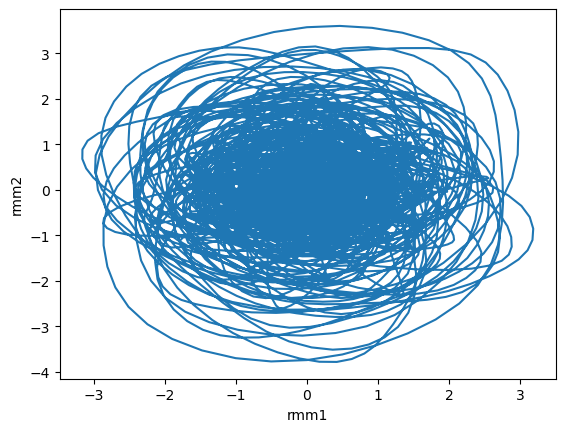

In [16]:
#plt.plot(rmm1,rmm2)
plt.plot(data[:,0][0:],data[:,1][0:])
plt.xlabel('rmm1')
plt.ylabel('rmm2')
plt.show()

In [17]:
'''
with h5py.File('/work/kuoray/for_paper/MJO_linear.h5', 'r') as hf500:
    traj = hf500['traj'][:]
rmm1 = traj[:,0]
rmm2 = traj[:,1]
plt.plot(traj[:,0],traj[:,1])
print(np.std(rmm1),np.std(rmm2))
'''

"\nwith h5py.File('/work/kuoray/for_paper/MJO_linear.h5', 'r') as hf500:\n    traj = hf500['traj'][:]\nrmm1 = traj[:,0]\nrmm2 = traj[:,1]\nplt.plot(traj[:,0],traj[:,1])\nprint(np.std(rmm1),np.std(rmm2))\n"

In [18]:
total = 200
xx,yy = np.meshgrid(np.linspace(-3,3,total),np.linspace(-3,3,total))
xx2   = xx.flatten()
yy2   = yy.flatten()
grids = np.vstack((xx2,yy2)).T
print(grids.shape)
print(data.shape)


(40000, 2)
(8888, 2)


In [22]:
deter = det_real_data(data,0.03,1e-5)

100%|█████████████████████████████████████| 8888/8888 [00:05<00:00, 1753.72it/s]


(-2.0, 2.0)

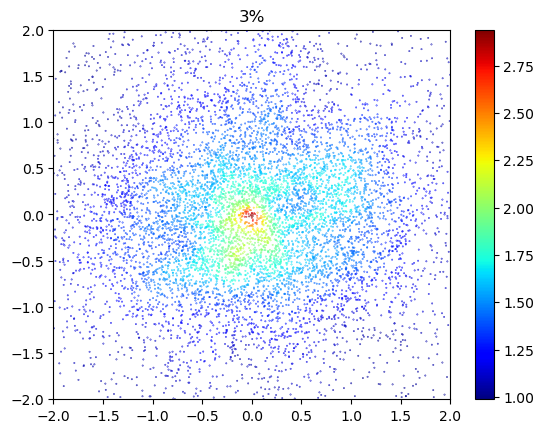

In [23]:
#c = (deter-np.mean(deter))/np.std(deter)
c = deter
#vmin=-7,vmax=7
plt.scatter(data[:,0],data[:,1],c=c,cmap='jet',s=0.1)
plt.colorbar()
plt.title('3%')
plt.xlim(-2,2)
plt.ylim(-2,2)
#plt.savefig('3_persent.png',dpi=300)

In [24]:
temp = deter2.reshape((total,total))
plt.contourf(xx,yy,temp,levels = np.linspace(0.84,1.15,200),cmap='jet')
#plt.contourf(xx,yy,temp,cmap='jet')
plt.colorbar()

NameError: name 'deter2' is not defined

In [25]:
X = data[:-1]
Y = data[1:] 
jaco = jacobian(X,Y,1e-15)
print(jaco)

[[ 0.9898255   0.09934118]
 [-0.09907646  0.98984708]]


[0.13363943 0.27931006]


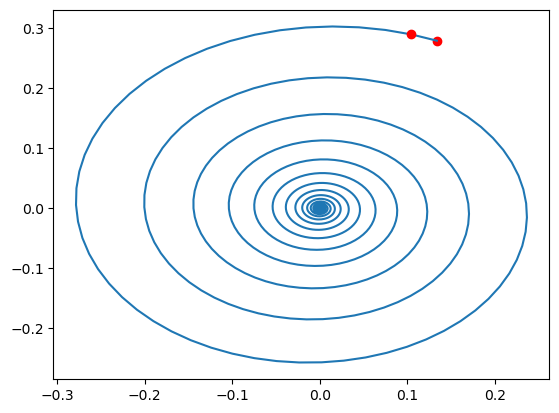

In [26]:
res = foward(Y[-1],jaco,10000)
plt.plot(Y[-1][0],Y[-1][1],'ro')
temp = Y[-1]@jaco
plt.plot(res[:,0],res[:,1])
plt.plot(temp[0],temp[1],'ro')
print(Y[-1])

In [27]:
covar = np.zeros((total*total,2,2))
for i in tqdm(range(total*total)):
        idx = find_nearest(grids[i],data,0.03)
        idx = idx[idx+1<data.shape[0]]
        num  = len(idx)
        x1    = data[idx+1]
        x1hat = data[idx]@jaco
        
        residual     = (x1[:,:]-x1hat[:,:])/np.sqrt(num)
        cov          =  residual.T@residual
        covar[i,:,:] = cov

100%|███████████████████████████████████| 40000/40000 [00:17<00:00, 2291.81it/s]


In [28]:
covar[100,:,:]
print(covar.shape)

(40000, 2, 2)


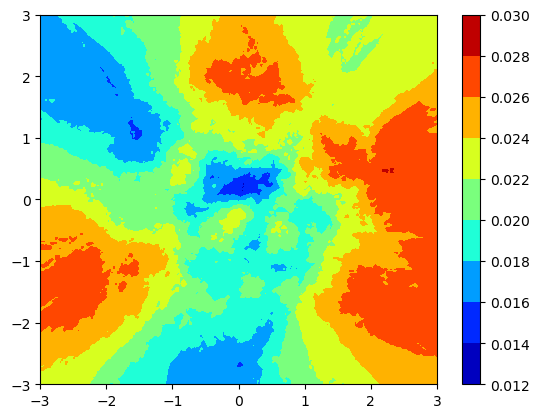

In [29]:
#plt.contourf(xx,yy,sigma,levels=np.arange(0.14,0.221,0.01),cmap='jet')
plt.contourf(xx,yy,(covar[:,1,1]+covar[:,0,0]).reshape((total,total)) ,cmap='jet')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.colorbar()
with h5py.File('sigma_observation.h5', 'w') as hf500:
    hf500['xx'] = xx
    hf500['yy'] = yy
    hf500['grids']  = grids
    hf500['covar']  = covar
    hf500['jaco']   = jaco